<a href="https://colab.research.google.com/github/Anshum/Keras/blob/master/4p_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Checking tensorflow version

In [2]:
%tensorflow_version 1.x
import tensorflow as tf
tf.__version__

'1.15.0'

Import Library

In [3]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 

# organize imports
#!pip install scipy
#!pip install sklearn
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import numpy as np
from keras.optimizers import SGD

import tensorflow as tf
from tensorflow.keras import layers

from tqdm import tqdm

# seed for reproducing same results
seed = 9
np.random.seed(seed)


from keras.layers import Input, Dense
from keras.models import Model
import keras.backend as K
from keras.callbacks import ReduceLROnPlateau, LambdaCallback
from keras.models import load_model
import os

Using TensorFlow backend.


Generate Prior Distribution

In [0]:
# Generating N random numbers that probability distribution
# fits to any given function curve
import math
import random
ndim=1 #Number of dimension
# define any function here!
def f(x):
    return (((x)**1/2)*((1-x)**1/2))
# f(x) = 1.0 : for uniform probability distribution

# f(x) = x : for triangular probability distribution
# (math.sqrt(random.random()) would also produce triangular p.d. though.)

# f(x) = math.exp(-x*x/2.0)/math.sqrt(2.0*math.pi) : for std normal p.d.
# (taking average of (last) 2,3,... random.random() values would also
# produce normal probability distributions though.)

n = 100000 # how many random numbers to generate
B=np.zeros((n,ndim))
for l in range(ndim):
    # define any xmin-xmax interval here! (xmin < xmax)
    xmin = 0.0
    xmax = 1.0
    # find ymin-ymax
    numSteps = 100000 # bigger the better but slower!
    ndmin = f(xmin)
    ndmax = ndmin
    for i in range(numSteps):
        x = xmin + (xmax - xmin) * float(i) / numSteps
        nd = f(x)
        if nd < ndmin: ndmin = nd
        if nd > ndmax: ndmax = nd
   
    xrs=np.zeros((n,1))
    for i in range(n):
        while True:
        # generate a random number between 0 to 1
            xr = random.random()
            ndr = random.random()
            x = xmin + (xmax - xmin) * xr
            nd = ndmin + (ndmax - ndmin) * ndr
            if nd <= f(x):
                xrs[i][0]=xmin+(xmax - xmin)*xr
                break
    s= np.reshape(xrs, (-1, 1))
    
    
    B[:,l]=np.transpose(s)

B;

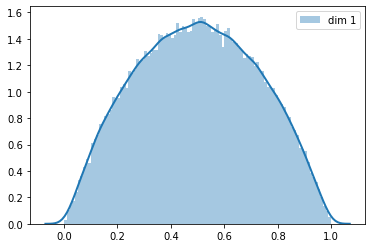

In [5]:
#Histogram Plot for prior distribution
import seaborn as sns
import matplotlib.pyplot as plt
for i in range(ndim):
    ndimp=i+1
    sns.distplot(B[:,i], label='dim %i' %ndimp, kde=True, bins=100, kde_kws={'linewidth': 2})
plt.legend()

Calculating prior distribution probability p(z)=f(z)/I where I is integration of f(z)

In [0]:
yb0=1
for i in range(ndim):
    yb0=yb0*f(B[:,i])


import scipy.integrate as integrate
re = integrate.quad(lambda x: f(x), 0,1)
pz=yb0/re[0]

Desired Distribution Type-1 $$f(x)=x^m(1-x)^n$$

In [0]:
pwr_m=10
pwr_n=1
def f_des_1(x):
    return (x**pwr_m)*((1-x)**pwr_n)
B3=np.random.random(10000)
fB3=f_des_1(B3)

Desired Distribution Type-2 $$f(x)=e^{x}f_s(x)$$

In [0]:
def f_des_1(x):
    x_t1=(2*x)-1
    x_t=np.arctanh(x_t1)
    
    return (np.exp(-(x_t)**2)*(((x_t**4))-0.4*(x_t**2)+0.3))
def f_des_1_tf(x):
    x_t1=(2*x)-1
    x_t=tf.atan(x_t1)
    return (tf.exp(-(x_t)**2)*(((x_t**4))-0.4*(x_t**2)+0.3))
B3=np.random.random(10000)
fB3=f_des_1(B3)

Plotting Desired function

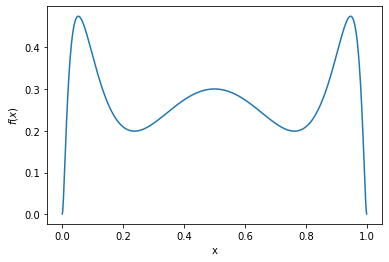

In [34]:
xx=np.linspace(0.001,0.999,1000)
plt.plot(xx,f_des_1(xx))
plt.xlabel('x')
plt.ylabel('$f(x)$')
plt.show()
plt.close()

Simplifying desired function to form $e^{g(x)}$ using Regression ML

Regression Model

N=ndim #dimension
N_hidden_r=32
inputs_r = Input(shape=(N,))
encoded_r = Dense(N_hidden_r, activation='elu', name='encoded_r')(inputs_r)
encoded2_r = Dense(N_hidden_r, activation='elu', name='encoded2_r')(encoded_r)
encoded3_r = Dense(N_hidden_r, activation='elu', name='encoded3_r')(encoded2_r)
encoded4_r = Dense(N_hidden_r, activation='elu', name='encoded4_r')(encoded3_r)
encoded5_r = Dense(N_hidden_r, activation='elu', name='encoded5_r')(encoded4_r)
outputs_r = Dense(N, activation='linear')(encoded5_r)
model_reg = Model(input=inputs_r, output=outputs_r)

Compiling and fitting of Regression model

def loss_reg(y_true, y_pred):
    return tf.abs(tf.log(y_true)-y_pred)
reduce_lr_r = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.0001)
model_reg.compile(optimizer='adam', metrics=['accuracy'], loss=loss_reg)
model_reg.fit(B3, fB3, batch_size=100, nb_epoch=50,callbacks=[reduce_lr_r],verbose=1)

Visual Confirmation of working of Regression model

regm=model_reg.predict(B3)

plt.scatter(B3,np.exp(regm[:,0]),label='Regression')
plt.scatter(B3,fB3,color='red',label='True Prior')
plt.xlabel('x')
plt.xlabel('f(x)')
plt.legend()
plt.show()

Generative Network model

In [0]:
N=ndim #dimension
def custom_activation(x):
    return (0.7*K.tanh(x)) +(0.3*x)
def custom_activation2(x):
    return ((1/(1+K.exp(-x))))

lam = 0 #cutoff to avoid log of zero used in loss function

O=N #used in jacobain #number of dimension

N_hidden=16
N_hidden2=32
N_hidden3=64

# inputs = Input(shape=(N,))
# encoded = Dense(N_hidden, activation=custom_activation, name='encoded')(inputs)
# encoded2 = Dense(N_hidden2, activation=custom_activation, name='encoded2')(encoded)
# encoded3 = Dense(N_hidden2, activation=custom_activation, name='encoded3')(encoded2)
# encoded4 = Dense(N_hidden2, activation=custom_activation, name='encoded4')(encoded3)
# encoded5 = Dense(N_hidden, activation=custom_activation, name='encoded5')(encoded4)
# outputs = Dense(N, activation=custom_activation2)(encoded5)

# model = Model(input=inputs, output=outputs)



model= Sequential()
model.add(Dense(N_hidden,activation=custom_activation,input_dim=N))
model.add(Dense(N_hidden2,activation=custom_activation))
model.add(Dense(N_hidden2,activation=custom_activation))
model.add(Dense(N_hidden3,activation=custom_activation))
model.add(Dense(N_hidden3,activation=custom_activation,))
model.add(Dense(N_hidden2,activation=custom_activation,))
model.add(Dense(N_hidden2,activation=custom_activation,))
model.add(Dense(N_hidden3,activation=custom_activation,))
model.add(Dense(N,activation='sigmoid'))

def jacobian_tensorflow3(x,y, verbose=False):    
    jacobian_matrix = []
    it = tqdm(range(O)) if verbose else range(O)
    for o in it:
        grad_func = tf.gradients(x[:, o], y)
        #gradients = sess.run(grad_func, feed_dict={model.input: x})
        jacobian_matrix.append(grad_func[0][0,:])
        #print('hello')
        #print(grad_func)
        #print(jacobian_matrix)
        
    return jacobian_matrix
def contractive_loss(y_pred, y_true):
    lam2=tf.constant(2.7**-3000)
    lam3=tf.constant(1e-4)
    lam5=tf.constant(-1e+3)
    jacobian_tf=jacobian_tensorflow3(model.output,model.input)
    loss=tf.abs(tf.linalg.det(jacobian_tf))
    #m1= y_pred
    m1=f(model.input)/re[0]
    mse3 = K.log(m1)-K.log(tf.math.maximum(loss,lam2))
    mse4=tf.constant(0.0)
    
    for i in range(ndim):
        #mse4=mse4+((pwr_m*K.log(model.output))+(pwr_n*K.log(1-model.output)))
        mse4=mse4+K.log((f_des_1_tf(model.output)))
        
    mse2=K.abs((mse3-mse4))
    
    #print(mse2)
    return K.mean(mse2)

def contractive_loss2(y_pred, y_true):
    #xr2=tf.cast(xr, tf.float64)
    jacobian_tf = jacobian_tensorflow3(model.output,model.input)
    fx=xr**2
    lam5=tf.constant(-1e+3)
    lam3=tf.constant(2.7**-70)
    #loss=xr-np.linalg.det(jacobian_tf)-fx
    loss=tf.abs(tf.linalg.det(jacobian_tf))
    mse =K.abs(K.log(tf.math.maximum(loss,lam3)))
    mse2 =loss
    return mse




Compiling the GNN

In [47]:
model.compile(optimizer='adam', metrics=['accuracy'], loss=contractive_loss)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.0001)
print_weights=LambdaCallback(on_epoch_begin=lambda batch,logs:print(model.get_weights()[0]))
print_lr=LambdaCallback(on_epoch_begin=lambda batch,logs:print(K.eval(model.optimizer.lr)))
model.fit(B, pz, batch_size=100, nb_epoch=20,callbacks=[reduce_lr],verbose=1)
print(K.eval(model.optimizer.lr))
#def on_epoch_end(self, epoch, logs=None):
#print(K.eval(self.mod
#del model
#Reload model
#model.get_weights()[0]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/20
100000/100000 [==============================] - 6s 58us/step - loss: 1.6962 - acc: 0.0000e+00
Epoch 2/20
100000/100000 [==============================] - 3s 35us/step - loss: 1.6841 - acc: 0.0000e+00
Epoch 3/20
100000/100000 [==============================] - 4s 35us/step - loss: 1.6631 - acc: 0.0000e+00
Epoch 4/20
100000/100000 [==============================] - 4s 35us/step - loss: 1.6064 - acc: 0.0000e+00
Epoch 5/20
100000/100000 [==============================] - 4s 35us/step - loss: 1.6370 - acc: 0.0000e+00
Epoch 6/20
100000/100000 [==============================] - 4s 35us/step - loss: 1.6049 - acc: 0.0000e+00
Epoch 7/20
100000/100000 [==============================] - 3s 35us/step - loss: 1.6017 - acc: 0.0000e+00
Epoch 8/20
100000/100000 [==============================] - 4s 36us/step - loss: 1.6193 - acc: 0.0000e+00
Epoch 9/20
100000/100000 [==============================] - 4s 37us/step - loss: 1.5713 - acc: 0.0000e+00
Epoch 10/20
100000/100000 [===================

Ploting the result without shake

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in arctanh
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in subtract
  """


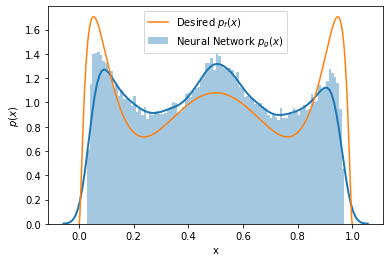

In [48]:
temp_graph = "./4p_graphs"
if not os.path.exists(temp_graph):
    os.makedirs(temp_graph)
pp=model.predict(B)
t=np.linspace(0,1,1000)
result = integrate.quad(lambda x: f_des_1(x), 0,1)
sns.distplot(pp[:,0], label='Neural Network $p_g(x)$', kde=True, bins=100,kde_kws={'linewidth': 2})
plt.plot(t,f_des_1(t)/result[0],label='Desired $p_f(x)$')
plt.xlabel('x')
plt.ylabel('$p(x)$')
plt.legend()
plt.savefig(temp_graph+"/image_without_shake.png")
plt.show()
plt.close()
#print(err)

Compiling with shaking of Weights

Iteration: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  del sys.path[0]


weighted root mean squre error of distribution= 0.4395344980942238
KL Divergence= 0.09702220533459846
actual integral value = 0.27790622704463075
grid numerical integral value = 0.28216706688491905 variance = 0.006160786936883513
Crude MC integral value = 0.27760689607760847 variance = 0.007047482443065953
GAN Importance Sampling numerical integral value = 0.26182719575624874 variance = 0.011587709107900315


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in arctanh
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in subtract
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


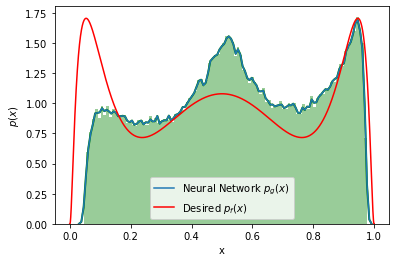

Iteration: 2
weighted root mean squre error of distribution= 0.4046371456975216
KL Divergence= 0.08187494697312886
actual integral value = 0.27790622704463075
grid numerical integral value = 0.2829124268609275 variance = 0.006159198905799407
Crude MC integral value = 0.2775650657965931 variance = 0.007079241215060372
GAN Importance Sampling numerical integral value = 0.26431435063895836 variance = 0.009052474128745103


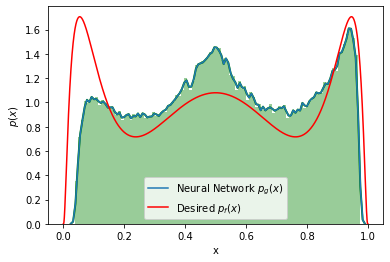

Iteration: 3
weighted root mean squre error of distribution= 0.4029351724371836
KL Divergence= 0.07878593564193684
actual integral value = 0.27790622704463075
grid numerical integral value = 0.2837180182312737 variance = 0.006077873212934641
Crude MC integral value = 0.2777153109977893 variance = 0.007142719582544033
GAN Importance Sampling numerical integral value = 0.26543682508513083 variance = 0.007659122017470932


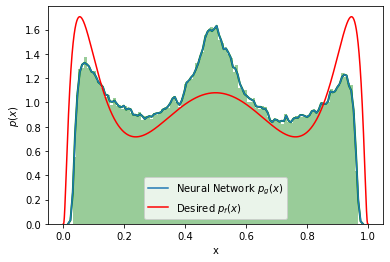

Iteration: 4
weighted root mean squre error of distribution= 0.4046750061741614
KL Divergence= 0.0792402803516636
actual integral value = 0.27790622704463075
grid numerical integral value = 0.2837217123881679 variance = 0.006077797283504467
Crude MC integral value = 0.2777991811866988 variance = 0.007094589113912836
GAN Importance Sampling numerical integral value = 0.26542345106375415 variance = 0.00765683928977888


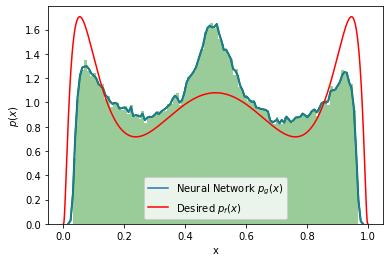

Iteration: 5
weighted root mean squre error of distribution= 0.32000665940914563
KL Divergence= 0.056535505708333864
actual integral value = 0.27790622704463075
grid numerical integral value = 0.28309832502725674 variance = 0.0060826137633603105
Crude MC integral value = 0.2775495750940113 variance = 0.007086023045156473
GAN Importance Sampling numerical integral value = 0.2685290547422544 variance = 0.004871307632945937


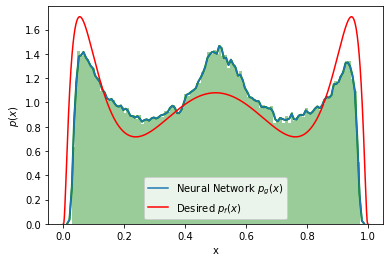

Iteration: 6
weighted root mean squre error of distribution= 0.29817393241615653
KL Divergence= 0.05117692870786793
actual integral value = 0.27790622704463075
grid numerical integral value = 0.2828081463476594 variance = 0.006112294746766093
Crude MC integral value = 0.2780211360369244 variance = 0.007084171417724536
GAN Importance Sampling numerical integral value = 0.26927113036725453 variance = 0.004190762690000557


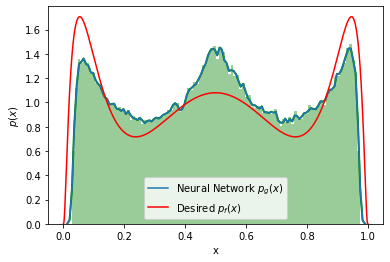

Iteration: 7


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in arctanh
  This is separate from the ipykernel package so we can avoid doing imports until


weighted root mean squre error of distribution= nan
KL Divergence= 0.030977992523114714
actual integral value = 0.27790622704463075
grid numerical integral value = nan variance = nan
Crude MC integral value = 0.27838139587536065 variance = 0.007176954288043089
GAN Importance Sampling numerical integral value = 0.27381030197132317 variance = 0.003094485158582183


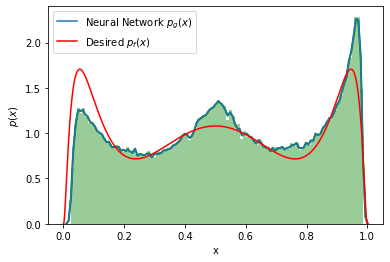

Iteration: 8
weighted root mean squre error of distribution= 0.3396017186998446
KL Divergence= 0.058766860101275686
actual integral value = 0.27790622704463075
grid numerical integral value = 0.2822999647266332 variance = 0.006260902146408048
Crude MC integral value = 0.2780647529875831 variance = 0.007132553285574647
GAN Importance Sampling numerical integral value = 0.2685240880725115 variance = 0.006103067534223627


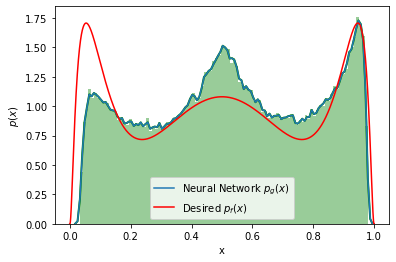

Iteration: 9
weighted root mean squre error of distribution= nan
KL Divergence= 0.010917185446566597
actual integral value = 0.27790622704463075
grid numerical integral value = nan variance = nan
Crude MC integral value = 0.27791403759977146 variance = 0.007116665866492483
GAN Importance Sampling numerical integral value = 0.27665642774067817 variance = 0.0009193264065627954


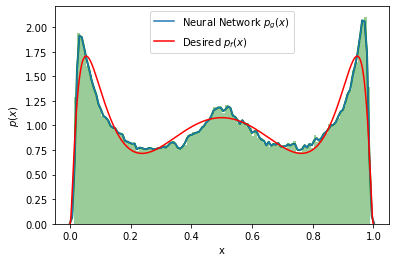

Iteration: 10
weighted root mean squre error of distribution= 0.2964361389758879
KL Divergence= 0.05023741186418652
actual integral value = 0.27790622704463075
grid numerical integral value = 0.2826425464480879 variance = 0.006134473263221894
Crude MC integral value = 0.27792460322804124 variance = 0.007153675696950509
GAN Importance Sampling numerical integral value = 0.26962207055198334 variance = 0.004291952050423792


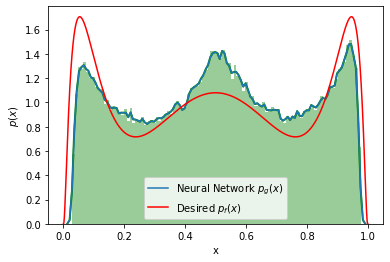

Iteration: 11
weighted root mean squre error of distribution= 0.2702140425535168
KL Divergence= 0.04114378830699993
actual integral value = 0.27790622704463075
grid numerical integral value = 0.2815599219705227 variance = 0.00634087255663219
Crude MC integral value = 0.2778946408903303 variance = 0.007107835028926993
GAN Importance Sampling numerical integral value = 0.27127515202822194 variance = 0.0037467614571956714


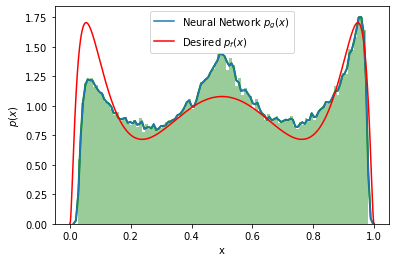

Iteration: 12
weighted root mean squre error of distribution= nan
KL Divergence= 0.025392010635520806
actual integral value = 0.27790622704463075
grid numerical integral value = nan variance = nan
Crude MC integral value = 0.2777842351614682 variance = 0.00715162770187408
GAN Importance Sampling numerical integral value = 0.27533354216497496 variance = 0.002481037228084404


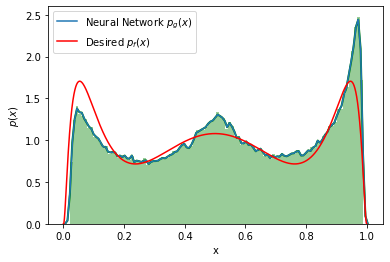

Iteration: 13
weighted root mean squre error of distribution= 0.42698127368827454
KL Divergence= 0.08697012752831905
actual integral value = 0.27790622704463075
grid numerical integral value = 0.28334872719318 variance = 0.006120359410234017
Crude MC integral value = 0.27811432464684754 variance = 0.007160460747554581
GAN Importance Sampling numerical integral value = 0.26426627468219105 variance = 0.00955225035956428


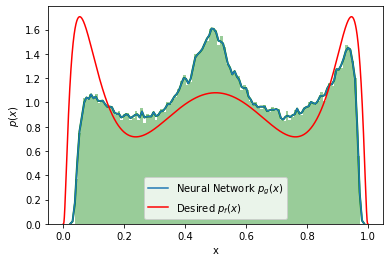

Iteration: 14
weighted root mean squre error of distribution= 0.3575150950678604
KL Divergence= 0.06345402242767932
actual integral value = 0.27790622704463075
grid numerical integral value = 0.2825438140390724 variance = 0.0062139782125618616
Crude MC integral value = 0.2776478858802275 variance = 0.0071366657978765985
GAN Importance Sampling numerical integral value = 0.26813350670792496 variance = 0.006781194974991148


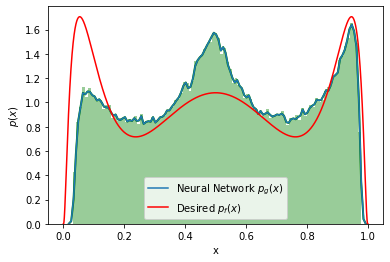

Iteration: 15
weighted root mean squre error of distribution= nan
KL Divergence= 0.013101721947425682
actual integral value = 0.27790622704463075
grid numerical integral value = nan variance = nan
Crude MC integral value = 0.2778068444278839 variance = 0.007065470572001464
GAN Importance Sampling numerical integral value = 0.27734947043128494 variance = 0.0015104203461917681


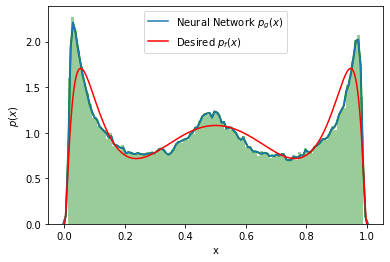

Iteration: 16
weighted root mean squre error of distribution= 0.3930778449516668
KL Divergence= 0.07621838644654953
actual integral value = 0.27790622704463075
grid numerical integral value = 0.28354887084407704 variance = 0.006083663711129183
Crude MC integral value = 0.2776698446722731 variance = 0.007091736529541093
GAN Importance Sampling numerical integral value = 0.26598357508034604 variance = 0.00796689509390873


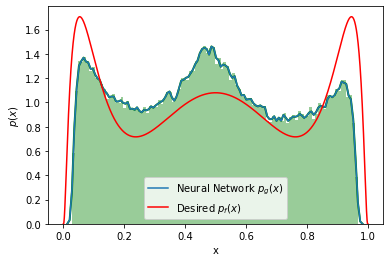

Iteration: 17
weighted root mean squre error of distribution= 0.3619585254382031
KL Divergence= 0.06635292365578808
actual integral value = 0.27790622704463075
grid numerical integral value = 0.282463953411935 variance = 0.006242216419774739
Crude MC integral value = 0.27784885807842385 variance = 0.007100195834775849
GAN Importance Sampling numerical integral value = 0.2673146196545873 variance = 0.007692948151897083


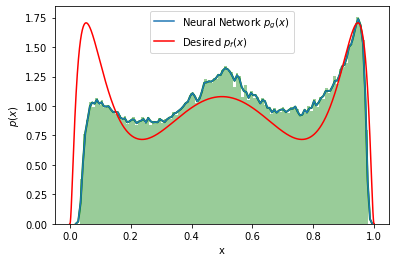

Iteration: 18
weighted root mean squre error of distribution= 0.33093267691952505
KL Divergence= 0.057710907768717915
actual integral value = 0.27790622704463075
grid numerical integral value = 0.2825930018684817 variance = 0.006185901196332579
Crude MC integral value = 0.27801674470517473 variance = 0.0070779936885690675
GAN Importance Sampling numerical integral value = 0.26872340768951447 variance = 0.006002153047974815


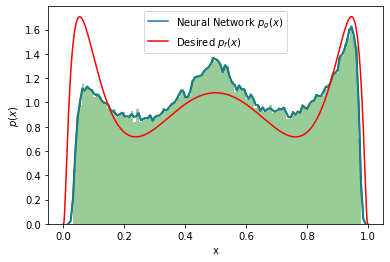

Iteration: 19
weighted root mean squre error of distribution= 0.30107203524531817
KL Divergence= 0.05149401611739643
actual integral value = 0.27790622704463075
grid numerical integral value = 0.2827213289000345 variance = 0.006122022911110639
Crude MC integral value = 0.2784174008382501 variance = 0.00711678029088865
GAN Importance Sampling numerical integral value = 0.26947405066733415 variance = 0.004604285722026577


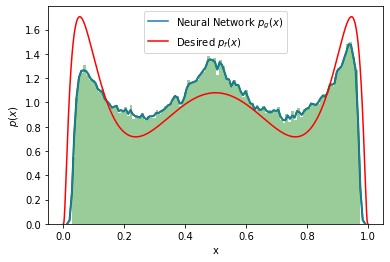

Iteration: 20
weighted root mean squre error of distribution= nan
KL Divergence= 0.012387571121710813
actual integral value = 0.27790622704463075
grid numerical integral value = nan variance = nan
Crude MC integral value = 0.2781445252055808 variance = 0.007172365001699321
GAN Importance Sampling numerical integral value = 0.2761024900920036 variance = 0.0008986394696197386


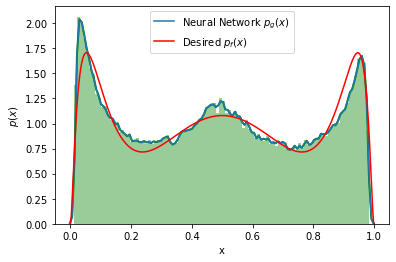

Iteration: 21
weighted root mean squre error of distribution= 0.3063829831422831
KL Divergence= 0.04981333369746422
actual integral value = 0.27790622704463075
grid numerical integral value = 0.2821829175957258 variance = 0.006215494428554149
Crude MC integral value = 0.2783663053054878 variance = 0.007077392754543582
GAN Importance Sampling numerical integral value = 0.2702837232819226 variance = 0.004941275089780664


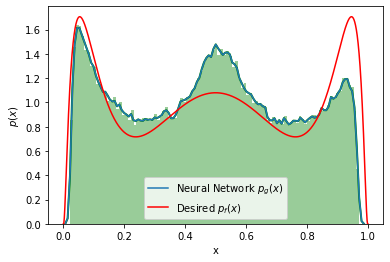

Iteration: 22
weighted root mean squre error of distribution= nan
KL Divergence= 0.014806839222044257
actual integral value = 0.27790622704463075
grid numerical integral value = nan variance = nan
Crude MC integral value = 0.2780168363647196 variance = 0.007125919447360532
GAN Importance Sampling numerical integral value = 0.27583363927409804 variance = 0.0011495999352182235


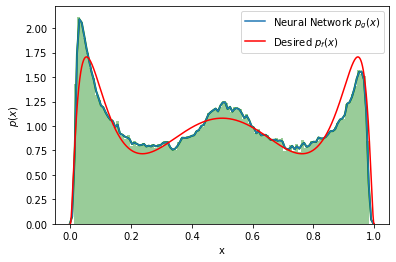

Iteration: 23
weighted root mean squre error of distribution= 0.28626001947544655
KL Divergence= 0.046997066582259
actual integral value = 0.27790622704463075
grid numerical integral value = 0.28230269809361025 variance = 0.0061743110812485305
Crude MC integral value = 0.2777708842433636 variance = 0.007093826625437366
GAN Importance Sampling numerical integral value = 0.2704489941077042 variance = 0.004047808387770371


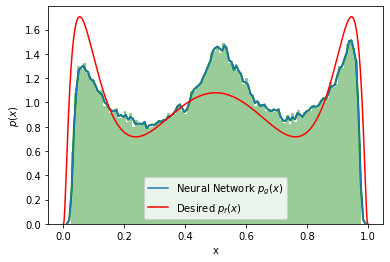

Iteration: 24
weighted root mean squre error of distribution= nan
KL Divergence= 0.014134774885586126
actual integral value = 0.27790622704463075
grid numerical integral value = nan variance = nan
Crude MC integral value = 0.2781002635847449 variance = 0.0071852379200436495
GAN Importance Sampling numerical integral value = 0.277404743040436 variance = 0.0015989841932558396


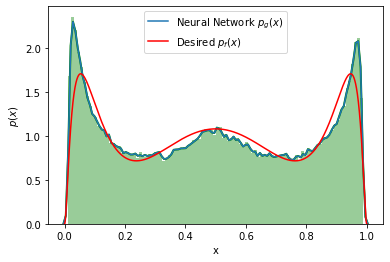

Iteration: 25
weighted root mean squre error of distribution= 0.21883874715210255
KL Divergence= 0.034027775068195404
actual integral value = 0.27790622704463075
grid numerical integral value = 0.28156349946735115 variance = 0.006288030892563164
Crude MC integral value = 0.27808796899684507 variance = 0.007068828502611174
GAN Importance Sampling numerical integral value = 0.27187039129436935 variance = 0.0024555210093263613


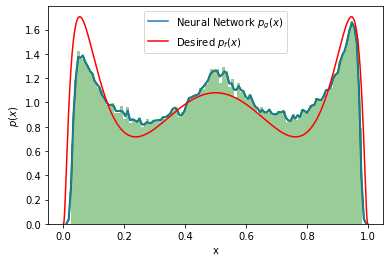

Iteration: 26
weighted root mean squre error of distribution= 0.4175827612060663
KL Divergence= 0.08543958647703499
actual integral value = 0.27790622704463075
grid numerical integral value = 0.28365334835010414 variance = 0.0061026633616786015
Crude MC integral value = 0.27803122267846564 variance = 0.00707847007675963
GAN Importance Sampling numerical integral value = 0.26396173297628606 variance = 0.009042017658221713


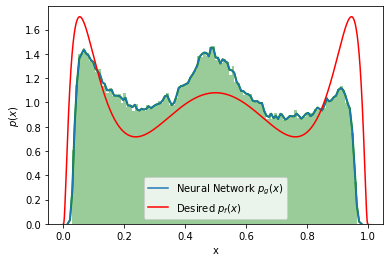

Iteration: 27
weighted root mean squre error of distribution= 0.26535133685775375
KL Divergence= 0.04401083786368771
actual integral value = 0.27790622704463075
grid numerical integral value = 0.28227421212511916 variance = 0.00619520728492035
Crude MC integral value = 0.27792419546027713 variance = 0.007078352900430462
GAN Importance Sampling numerical integral value = 0.27024877297550376 variance = 0.0035407930497393103


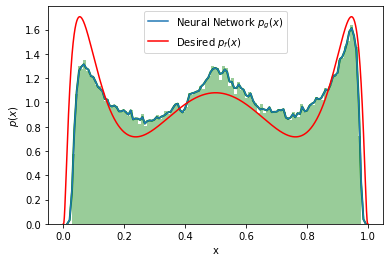

Iteration: 28
weighted root mean squre error of distribution= 0.27904595013245453
KL Divergence= 0.0455616744904366
actual integral value = 0.27790622704463075
grid numerical integral value = 0.2822169416405484 variance = 0.006209645356246672
Crude MC integral value = 0.2779960035952662 variance = 0.00711144562557188
GAN Importance Sampling numerical integral value = 0.2702831729774775 variance = 0.003983033821678028


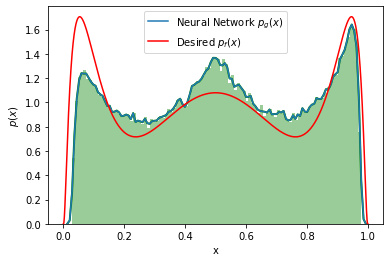

Iteration: 29
weighted root mean squre error of distribution= 0.3403738123515902
KL Divergence= 0.05836447570147816
actual integral value = 0.27790622704463075
grid numerical integral value = 0.2820806619353403 variance = 0.006306811901655215
Crude MC integral value = 0.27780780639760816 variance = 0.007095675652759023
GAN Importance Sampling numerical integral value = 0.26884027196913507 variance = 0.006548291316468474


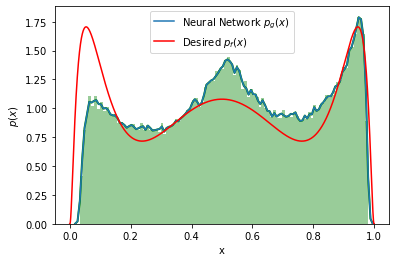

Iteration: 30
weighted root mean squre error of distribution= nan
KL Divergence= 0.01640318635749842
actual integral value = 0.27790622704463075
grid numerical integral value = nan variance = nan
Crude MC integral value = 0.27769499062879416 variance = 0.007089592652637852
GAN Importance Sampling numerical integral value = 0.27527317943818813 variance = 0.0011593966878405138


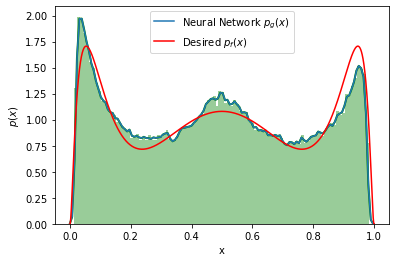

Iteration: 31
weighted root mean squre error of distribution= 0.23867888862409098
KL Divergence= 0.030090530665685355
actual integral value = 0.27790622704463075
grid numerical integral value = 0.2801365901090321 variance = 0.006612096669894185
Crude MC integral value = 0.27777006835159984 variance = 0.007121069151615755
GAN Importance Sampling numerical integral value = 0.27345476227664284 variance = 0.002906355236571123


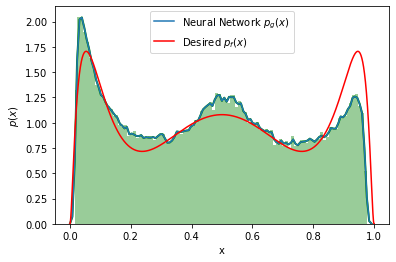

Iteration: 32
weighted root mean squre error of distribution= 0.24066026044866595
KL Divergence= 0.036450004633155966
actual integral value = 0.27790622704463075
grid numerical integral value = 0.2815571825483662 variance = 0.006288823125823935
Crude MC integral value = 0.27803414440186325 variance = 0.007050213425361163
GAN Importance Sampling numerical integral value = 0.2718377800598599 variance = 0.0029882041583090685


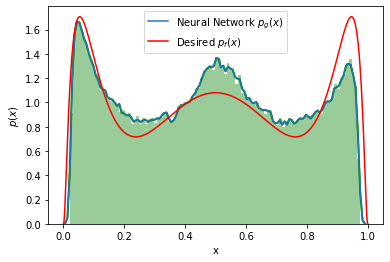

Iteration: 33
weighted root mean squre error of distribution= 0.3667143641571116
KL Divergence= 0.06869477154011185
actual integral value = 0.27790622704463075
grid numerical integral value = 0.2834688820077939 variance = 0.006070034547399349
Crude MC integral value = 0.2783322741707126 variance = 0.007085199527164618
GAN Importance Sampling numerical integral value = 0.26701532350634466 variance = 0.006618554429098519


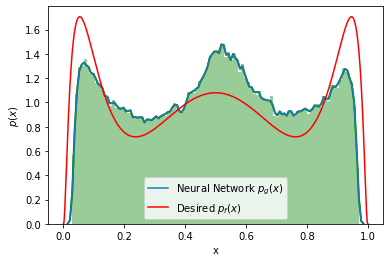

Iteration: 34
weighted root mean squre error of distribution= nan
KL Divergence= 0.01506223850147797
actual integral value = 0.27790622704463075
grid numerical integral value = nan variance = nan
Crude MC integral value = 0.2780870550628824 variance = 0.007158017946274478
GAN Importance Sampling numerical integral value = 0.2756862269931229 variance = 0.0011098107079025726


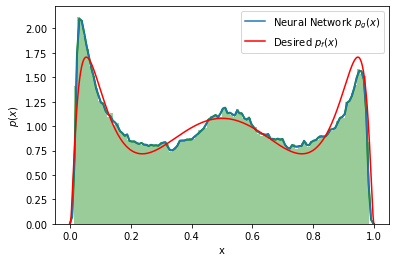

Iteration: 35
weighted root mean squre error of distribution= 0.3331185217341095
KL Divergence= 0.05986699867731306
actual integral value = 0.27790622704463075
grid numerical integral value = 0.28276757303865563 variance = 0.006164146338122157
Crude MC integral value = 0.27770224697670653 variance = 0.007105366050095888
GAN Importance Sampling numerical integral value = 0.26818645147100006 variance = 0.005807950827699693


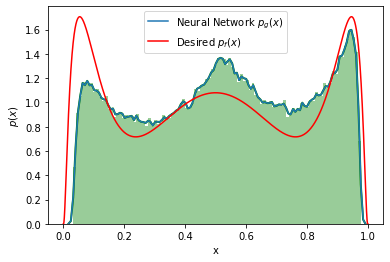

Iteration: 36
weighted root mean squre error of distribution= 0.40046112326990957
KL Divergence= 0.07813046220362706
actual integral value = 0.27790622704463075
grid numerical integral value = 0.2836184934644103 variance = 0.006084151436872393
Crude MC integral value = 0.27783820299659395 variance = 0.0071084161821705905
GAN Importance Sampling numerical integral value = 0.2656046040294015 variance = 0.008028935966929288


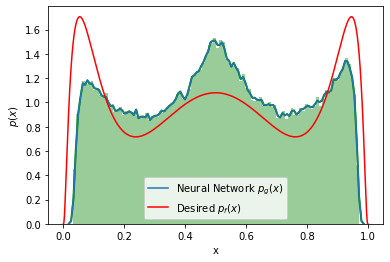

Iteration: 37
weighted root mean squre error of distribution= nan
KL Divergence= 0.016859003364053684
actual integral value = 0.27790622704463075
grid numerical integral value = nan variance = nan
Crude MC integral value = 0.27815042153469804 variance = 0.007090218659386749
GAN Importance Sampling numerical integral value = 0.2751537590892229 variance = 0.0011797523869788995


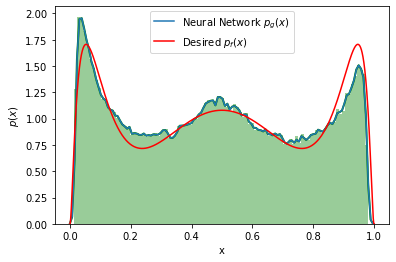

Iteration: 38
weighted root mean squre error of distribution= nan
KL Divergence= 0.04117177480856737
actual integral value = 0.27790622704463075
grid numerical integral value = nan variance = nan
Crude MC integral value = 0.27811017071331606 variance = 0.007126369611132097
GAN Importance Sampling numerical integral value = 0.2721851639247148 variance = 0.0048854649558672525


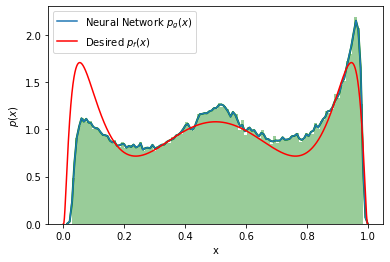

Iteration: 39
weighted root mean squre error of distribution= 0.26828418387389646
KL Divergence= 0.04295089183246727
actual integral value = 0.27790622704463075
grid numerical integral value = 0.2821131230752463 variance = 0.006191542646404579
Crude MC integral value = 0.2782408871836142 variance = 0.007122223669230002
GAN Importance Sampling numerical integral value = 0.2709541965991132 variance = 0.0036724634896913855


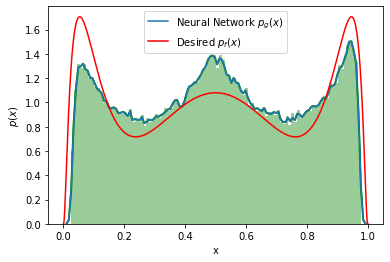

Iteration: 40
weighted root mean squre error of distribution= 0.3206939199230556
KL Divergence= 0.05338835589794205
actual integral value = 0.27790622704463075
grid numerical integral value = 0.2822416238988216 variance = 0.00622477958324484
Crude MC integral value = 0.27745856034861777 variance = 0.007020244185961644
GAN Importance Sampling numerical integral value = 0.2698119696105234 variance = 0.005607627318210032


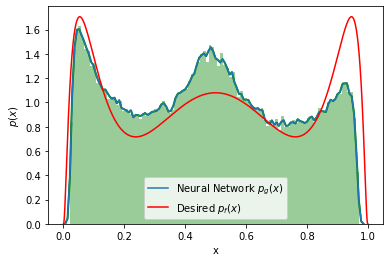

Iteration: 41
weighted root mean squre error of distribution= 0.3507182632095999
KL Divergence= 0.06307620850151885
actual integral value = 0.27790622704463075
grid numerical integral value = 0.2831927936580544 variance = 0.006078857181707481
Crude MC integral value = 0.2780000714926002 variance = 0.007073544870783613
GAN Importance Sampling numerical integral value = 0.26814854846864933 variance = 0.006221565733970383


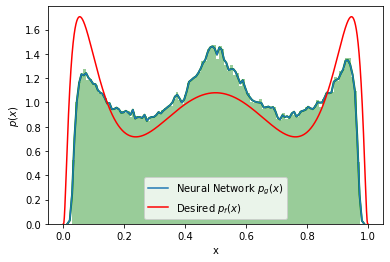

Iteration: 42
weighted root mean squre error of distribution= 0.41853721293971413
KL Divergence= 0.08302529957803155
actual integral value = 0.27790622704463075
grid numerical integral value = 0.28369761178525477 variance = 0.006083785969426126
Crude MC integral value = 0.27798099030506745 variance = 0.007128554559742664
GAN Importance Sampling numerical integral value = 0.2652162272398085 variance = 0.009048275141420856


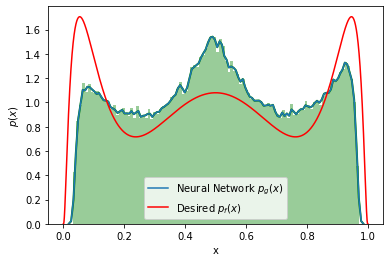

Iteration: 43
weighted root mean squre error of distribution= 0.1574262769508759
KL Divergence= 0.020517287964601567
actual integral value = 0.27790622704463075
grid numerical integral value = 0.27981176517968764 variance = 0.006628859539075736
Crude MC integral value = 0.2778481271265724 variance = 0.007121529417436698
GAN Importance Sampling numerical integral value = 0.27437488588910697 variance = 0.0013438675756477225


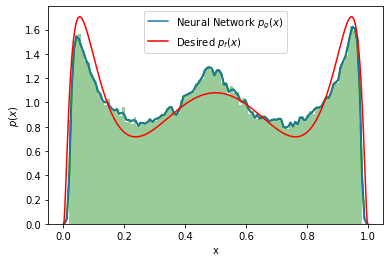

Iteration: 44
weighted root mean squre error of distribution= nan
KL Divergence= 0.01408523913239472
actual integral value = 0.27790622704463075
grid numerical integral value = nan variance = nan
Crude MC integral value = 0.27775713017864206 variance = 0.00707026116480905
GAN Importance Sampling numerical integral value = 0.277580062821593 variance = 0.0016628041636429503


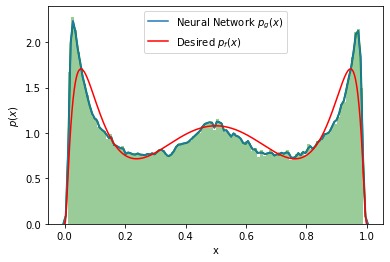

Iteration: 45
weighted root mean squre error of distribution= 0.24087683167081705
KL Divergence= 0.036323174216940333
actual integral value = 0.27790622704463075
grid numerical integral value = 0.28146531737372893 variance = 0.006310823973930488
Crude MC integral value = 0.27788014227422564 variance = 0.0071261279245892345
GAN Importance Sampling numerical integral value = 0.27192656992272735 variance = 0.0030318677931694266


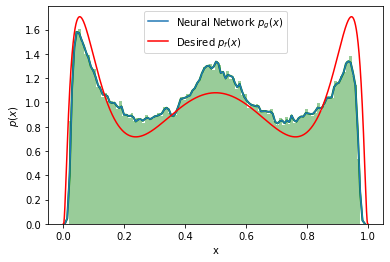

Iteration: 46
weighted root mean squre error of distribution= 0.15985420924786883
KL Divergence= 0.021384619025303996
actual integral value = 0.27790622704463075
grid numerical integral value = 0.2799942935197878 variance = 0.006587901983604198
Crude MC integral value = 0.2779942775926455 variance = 0.0071491876558942985
GAN Importance Sampling numerical integral value = 0.27415300287210376 variance = 0.0013750941074123363


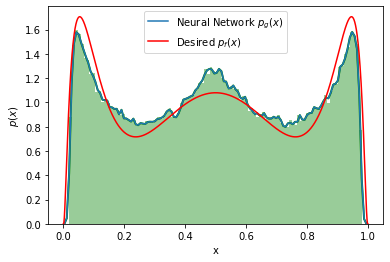

Iteration: 47
weighted root mean squre error of distribution= nan
KL Divergence= 0.05549808184137962
actual integral value = 0.27790622704463075
grid numerical integral value = nan variance = nan
Crude MC integral value = 0.27762149988972984 variance = 0.007030522380009965
GAN Importance Sampling numerical integral value = 0.2711881927479097 variance = 0.007784827211863507


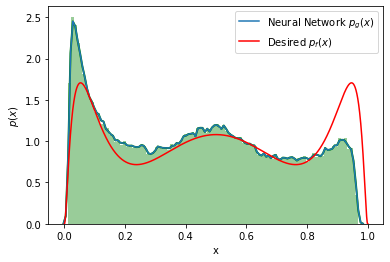

Iteration: 48
weighted root mean squre error of distribution= 0.28617070875721384
KL Divergence= 0.047442144949217474
actual integral value = 0.27790622704463075
grid numerical integral value = 0.2823935290097039 variance = 0.006147679992499711
Crude MC integral value = 0.2784432339248764 variance = 0.0071063881680905605
GAN Importance Sampling numerical integral value = 0.2704274221454089 variance = 0.004317757042165582


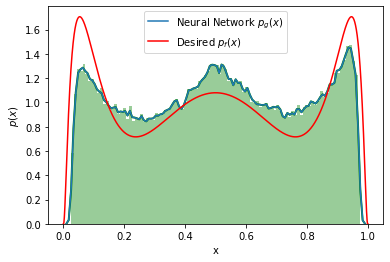

Iteration: 49
weighted root mean squre error of distribution= nan
KL Divergence= 0.027925813335544766
actual integral value = 0.27790622704463075
grid numerical integral value = nan variance = nan
Crude MC integral value = 0.27800115163108546 variance = 0.007048163302197444
GAN Importance Sampling numerical integral value = 0.27369073504087443 variance = 0.0026270555993021943


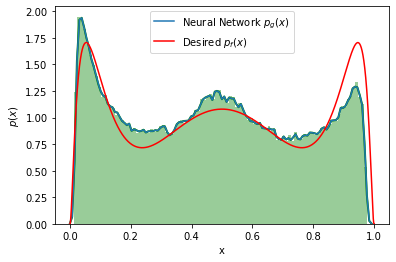

Iteration: 50
weighted root mean squre error of distribution= 0.1630820689063715
KL Divergence= 0.022990592256585927
actual integral value = 0.27790622704463075
grid numerical integral value = 0.2802385691196368 variance = 0.006532640829553644
Crude MC integral value = 0.27764427409633097 variance = 0.007108759413608376
GAN Importance Sampling numerical integral value = 0.27387948275049745 variance = 0.0015086816437892003


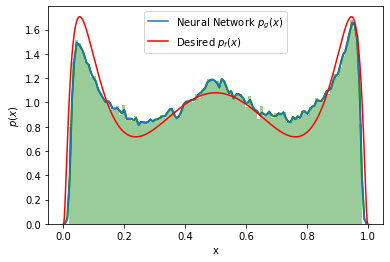

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.integrate as integrate
for i in range(50):
    print('Iteration: '+str(i+1))
    model.save_weights('my_model_weights.h5')
    model.load_weights('my_model_weights.h5',by_name=True)
    #model.get_weights()
    #np.array(model.get_weights())[0].shape
    sw=[np.array(model.get_weights())[i]*np.random.normal(1,0.05,np.array(model.get_weights())[i].shape) for i in range(np.array(model.get_weights()).shape[0])]
    model.set_weights(sw)
    model.fit(B, pz, nb_epoch=10, batch_size=3000,callbacks=[reduce_lr],verbose=0)
    result = integrate.quad(lambda x: f_des_1(x), 0,1)
   # integ = vegas.Integrator([[0, 1]])
    pp=model.predict(B)
    #t=np.linspace(0.001,0.999,100000)
    s=sns.distplot(pp[:,0],color='green',bins=100,kde=True,kde_kws={'linewidth': 2,'bw': 0.005})
    pp=model.predict(B)
    data = s.get_lines()[0].get_data()
    #f = scipy.interpolate.interp1d(data[0], data[1],fill_value="extrapolate")
    f_des_interpolate = scipy.interpolate.interp1d(data[0], data[1],fill_value='extrapolate')
    t=np.linspace(min(data[0]),max(data[0]),100000)
    err=np.sqrt(np.mean(np.square(f_des_interpolate(t)-(f_des_1(t)/result[0]))*(f_des_1(t)/result[0])))
    print('weighted root mean squre error of distribution= '+str(err))
    print('KL Divergence= '+str(np.abs(np.mean(np.log(f_des_1(pp[:,0])/result[0])-np.log(f_des_interpolate(pp[:,0]))))))
    print('actual integral value = '+str(result[0]))
    print('grid numerical integral value = '+str(np.mean(f_des_1(t)))+' variance = '+str(np.mean(((f_des_1(t)**2))-np.square(np.mean(f_des_1(t))))))
    ran=np.random.random(100000)
    print('Crude MC integral value = '+str(np.mean(f_des_1(ran)))+' variance = '+str(np.mean(((f_des_1(ran))**2))-np.square(np.mean(f_des_1(ran)))))
    #print('Importance Sampling from [x*(1-x)]^(1/2) numerical integral value = '+str(np.mean(f2(B[:,0])/((B[:,0]*(1-B[:,0]))**(1/2)))))
    #print('vegas Integration = '+str(integ(f2, nitn=10, neval=10000)))
    print('GAN Importance Sampling numerical integral value = '+str(np.mean(f_des_1(pp[:,0])/f_des_interpolate(pp[:,0])))+' variance = '+str(np.mean(((f_des_1(pp[:,0]))**2)/((f_des_interpolate(pp[:,0]))**2))-np.square(np.mean(f_des_1(pp[:,0])/f_des_interpolate(pp[:,0])))))
    plt.plot(t,f_des_interpolate(t),label='Neural Network $p_g(x)$')
    t2=np.linspace(0,1,100000)
    plt.plot(t2,(f_des_1(t2)/result[0]),'red',label='Desired $p_f(x)$')
    plt.xlabel('x')
    plt.ylabel('$p(x)$')
    plt.legend()
    plt.legend()
    plt.savefig(temp_graph+"/image_shake_%d.png"%(i+1))
    plt.show()
    plt.close()
